Import Important  Libraries


In [7]:
import subprocess
import self as self
import sns as sns
import  tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import voting as voting
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, VotingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from imblearn.over_sampling import RandomOverSampler

In [8]:
df = pd.read_csv (r'D:\uottawa\smart cities\final project\MCSDatasetNEXTCONLab.csv')
df.head()

,ID,Latitude,Longitude,Day,Hour,Minute,Duration,RemainingTime,Resources,Coverage,OnPeakHours,GridNumber,Ligitimacy
0,1,45.442142,-75.303369,1,4,13,40,40,9,91,0,131380,1
1,1,45.442154,-75.304366,1,4,23,40,30,9,91,0,131380,1
2,1,45.442104,-75.303963,1,4,33,40,20,9,91,0,121996,1
3,1,45.441868,-75.303577,1,4,43,40,10,9,91,0,121996,1
4,2,45.447727,-75.147722,2,15,49,30,30,5,47,0,140784,1


In [9]:
x = df.iloc[:, 0:12]
y = df.iloc[:, 12]

In [10]:
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=42)

In [11]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(-1, 1))
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

In [88]:
##Implement  classic classifier Adaboot and RD

In [12]:
def models(model, x, y):
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
    model = model.fit(x_train, y_train)
    y_train_pred = model.predict(x_train)
    y_test_pred = model.predict(x_test)
    accuracy_train = accuracy_score(y_train, y_train_pred)
    accuracy_test = accuracy_score(y_test, y_test_pred)
    report_test = classification_report(y_test, y_test_pred)
    return (model, y_train_pred, y_test_pred, accuracy_train, accuracy_test, report_test)

In [13]:
RF, AB = RandomForestClassifier(), AdaBoostClassifier()
#Rf
model_RF, y_train_pred_RF, y_test_pred_RF, accuracy_train_RF, accuracy_test_RF, report_RF = models(RF, x, y)
#AB
model_AB, y_train_pred_AB, y_test_pred_AB, accuracy_train_AB, accuracy_test_AB, report_AB = models(AB, x, y)

In [14]:
print(report_RF)

              precision    recall  f1-score   support

           0       1.00      0.97      0.98       354
           1       1.00      1.00      1.00      2543

    accuracy                           1.00      2897
   macro avg       1.00      0.98      0.99      2897
weighted avg       1.00      1.00      1.00      2897



In [15]:
accuracy_test_RF

0.9958577839143942

In [16]:
print(report_AB)

              precision    recall  f1-score   support

           0       0.87      0.74      0.80       354
           1       0.96      0.98      0.97      2543

    accuracy                           0.95      2897
   macro avg       0.92      0.86      0.89      2897
weighted avg       0.95      0.95      0.95      2897



In [17]:
accuracy_test_AB

0.9540904383845358

## Bar Chart for RF and AB

In [93]:
from sklearn.ensemble import VotingClassifier

In [18]:
df_2 = pd.DataFrame({'Model':['Random Forest', 'AdaBoost'],
'Accuracy on Training Data':[accuracy_train_RF, accuracy_train_AB,
                             ],
'Accuracy on Testing Data':[accuracy_test_RF, accuracy_test_AB,
                            ] ,
})

In [19]:
import seaborn as sns

(0.0, 1.0)

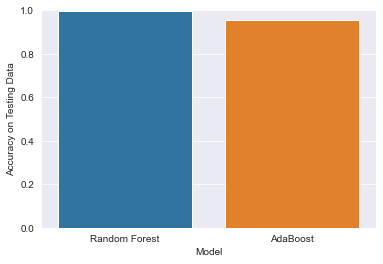

In [20]:
#for testing data
bar_plot_test = sns.barplot(data = df_2, x = 'Model', y = 'Accuracy on Testing Data')
bar_plot_test.set_ylim(0, 1)


Constants and hyperparameters

In [22]:
batch_size = 128
num_classes =2
latent_dim = 128


In [23]:
from tensorflow import keras
from keras import layers
import tensorflow as tf

In [24]:

all_labels = keras.utils.to_categorical(y_train,2)
x_train=x_train.astype(np.float32)
# Create tf.data.Dataset.
dataset = tf.data.Dataset.from_tensor_slices((x_train, all_labels))
dataset = dataset.shuffle(buffer_size=1024).batch(batch_size)

print(f"Shape of training Tasks: {x_train.shape}")
print(f"Shape of training labels: {all_labels.shape}")

Shape of training Tasks: (11587, 12)
Shape of training labels: (11587, 2)


Calculating the number of input channel for the generator and discriminator

In [25]:
generator_in_channels = latent_dim + num_classes
discriminator_in_channels = 12 + num_classes
print(generator_in_channels, discriminator_in_channels)

130 14


Create Discriminator

In [26]:
discriminator = keras.Sequential(
    [
        keras.layers.Input(shape=(discriminator_in_channels,1)),
        layers.Conv1D(64, 3, strides=2, padding="same",),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv1D(128, 3, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.GlobalMaxPooling1D(),
        layers.Dense(1,activation='sigmoid'),
    ],
    name="discriminator",
)
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 7, 64)             256       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 7, 64)             0         
                                                                 
 conv1d_1 (Conv1D)           (None, 4, 128)            24704     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 4, 128)            0         
                                                                 
 global_max_pooling1d (Globa  (None, 128)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                     

Create Generator

In [27]:
generator = keras.Sequential(
    [
        keras.layers.InputLayer((generator_in_channels,)),
        layers.Dense(256),
        layers.LeakyReLU(alpha=0.2),
        layers.Dense(128),
        layers.LeakyReLU(alpha=0.2),
        layers.Dense(128,),
        layers.LeakyReLU(alpha=0.2),
        layers.Dense(12,),
    ],
    name="generator",
)
generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 256)               33536     
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 128)               16512     
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 128)               0         
                                                                 
 dense_4 (Dense)             (None, 12)                15

CGAN Model

In [28]:
class ConditionalGAN(keras.Model):
    def __init__(self, discriminator,generator, latent_dim):
        super(ConditionalGAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.gen_loss_tracker = keras.metrics.Mean(name="generator_loss")
        self.disc_loss_tracker = keras.metrics.Mean(name="discriminator_loss")

    @property
    def metrics(self):
        return [self.gen_loss_tracker, self.disc_loss_tracker]

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(ConditionalGAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn

    def train_step(self, data):
        # Unpack the data.
        real_Tasks, one_hot_labels = data



        # Sample random points in the latent space and concatenate the labels.
        # This is for the generator.
        batch_size = tf.shape(real_Tasks)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        random_vector_labels = tf.concat(
            [random_latent_vectors, one_hot_labels], axis=1
        )

        # Decode the noise (guided by labels) to fake Tasks.
        generated_Tasks = self.generator(random_vector_labels)

        # Combine them with real TASKS . Note that we are concatenating the labels
        # with these tasks here.
        fake_tasks_and_labels = tf.concat([generated_Tasks, one_hot_labels],axis=1)
        real_task_with_labels=tf.concat([real_Tasks,one_hot_labels],axis=1)

        combined_tasks = tf.concat(
            [fake_tasks_and_labels, real_task_with_labels], axis=0
        )

        # Assemble labels discriminating real from fake tasks.
        labels = tf.concat(
            [tf.zeros((batch_size, 1)), tf.ones((batch_size, 1))], axis=0
        )

        # Train the discriminator.
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_tasks)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # Sample random points in the latent space.
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        random_vector_labels = tf.concat(
            [random_latent_vectors, one_hot_labels], axis=1
        )

        # Assemble labels that say "all real images".
        misleading_labels = tf.ones((batch_size, 1))

        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            fake_tasks = self.generator(random_vector_labels)
            fake_tasks_and_labels = tf.concat([fake_tasks, one_hot_labels], -1)
            predictions = self.discriminator(fake_tasks_and_labels)
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Monitor loss.
        self.gen_loss_tracker.update_state(g_loss)
        self.disc_loss_tracker.update_state(d_loss)
        return {
            "g_loss": self.gen_loss_tracker.result(),
            "d_loss": self.disc_loss_tracker.result(),
        }
cond_gan = ConditionalGAN(
    discriminator=discriminator, generator=generator, latent_dim=latent_dim
)
cond_gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0003),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0003),
    loss_fn=keras.losses.BinaryCrossentropy(),
)

cond_gan.fit(dataset, epochs=20)

Epoch 1/20
91/91 [==============================] - 3s 7ms/step - g_loss: 0.6856 - d_loss: 0.7140
Epoch 2/20
91/91 [==============================] - 1s 7ms/step - g_loss: 1.3587 - d_loss: 0.6018
Epoch 3/20
91/91 [==============================] - 1s 7ms/step - g_loss: 0.7307 - d_loss: 0.7155
Epoch 4/20
91/91 [==============================] - 1s 7ms/step - g_loss: 0.6387 - d_loss: 0.7181
Epoch 5/20
91/91 [==============================] - 1s 7ms/step - g_loss: 0.6570 - d_loss: 0.7017
Epoch 6/20
91/91 [==============================] - 1s 7ms/step - g_loss: 0.7005 - d_loss: 0.6785
Epoch 7/20
91/91 [==============================] - 1s 7ms/step - g_loss: 0.7003 - d_loss: 0.6905
Epoch 8/20
91/91 [==============================] - 1s 7ms/step - g_loss: 0.7260 - d_loss: 0.6935
Epoch 9/20
91/91 [==============================] - 1s 7ms/step - g_loss: 0.7219 - d_loss: 0.6866
Epoch 10/20
91/91 [==============================] - 1s 7ms/step - g_loss: 0.6796 - d_loss: 0.6844
Epoch 11/20
91/91 [

In [29]:
#We first extract the trained generator from our Conditiona GAN.
trained_gen = cond_gan.generator

# Choose the number of intermediate Tasks that would be generated in
# between the interpolation + 2 (start and last TASKS).
num_tasks = 1000  # @param {type:"integer"}

# Sample noise for the interpolation.
noise = tf.random.normal(shape=(num_tasks, latent_dim))
noise_with_label=tf.concat([noise,keras.utils.to_categorical([0]*num_tasks,2)],1)

fake_tasks=trained_gen.predict(noise_with_label)
fake_tasks=pd.DataFrame(scaler.inverse_transform(fake_tasks),columns=df.columns[0:12])
fake_tasks

32/32 [==============================] - 0s 1ms/step


,ID,Latitude,Longitude,Day,Hour,Minute,Duration,RemainingTime,Resources,Coverage,OnPeakHours,GridNumber
0,2164.191406,45.525280,-75.250420,3.234113,18.733908,50.271618,33.131824,37.222622,9.351373,65.270920,0.065401,196024.218750
1,2654.715088,45.537876,-75.252861,3.193758,17.586891,52.816406,31.906689,37.692921,9.807094,55.841099,0.035596,183793.390625
2,2793.319336,45.535858,-75.268608,3.711390,18.019270,55.651287,35.540157,42.264355,9.724212,67.410965,0.011787,189091.484375
3,2447.290527,45.540722,-75.238930,3.147765,16.152683,48.160370,38.465481,44.436760,9.722855,63.353432,0.207019,203018.296875
4,2616.924805,45.517120,-75.252983,3.229619,16.571630,48.567574,38.402740,44.091831,9.684939,57.219501,0.086321,200958.437500
...,...,...,...,...,...,...,...,...,...,...,...,...
995,2911.718506,45.538204,-75.299927,3.202884,18.344418,50.038589,36.223682,41.391911,11.232533,56.283077,-0.140102,220041.046875
996,2764.692871,45.559906,-75.267921,3.102384,19.564892,55.206802,29.392933,41.252239,10.644953,50.007210,-0.176534,219416.609375
997,2550.270508,45.557354,-75.249130,3.172266,18.796974,52.730751,35.779236,39.912083,11.910395,51.306702,0.006625,217897.140625
998,2510.116699,45.521545,-75.302826,3.221419,16.367828,50.451279,36.394600,48.959949,11.149899,49.521553,-0.040699,188033.609375


Step 10 using mixed data set

New dataset with fake tasks

Without Discriminator

In [30]:
New_x_Test = np.concatenate((fake_tasks,x_test) , axis = 0)
New_y_Test =  np.concatenate((y_test.values,np.zeros(num_tasks)), axis = 0).astype("int")
New_x_Test

array([[ 2.16419141e+03,  4.55252800e+01, -7.52504196e+01, ...,
         6.52709198e+01,  6.54008389e-02,  1.96024219e+05],
       [ 2.65471509e+03,  4.55378761e+01, -7.52528610e+01, ...,
         5.58410988e+01,  3.55958343e-02,  1.83793391e+05],
       [ 2.79331934e+03,  4.55358582e+01, -7.52686081e+01, ...,
         6.74109650e+01,  1.17872655e-02,  1.89091484e+05],
       ...,
       [-9.77744436e-02,  7.10110181e-01, -5.07246183e-01, ...,
        -1.71428571e-01, -1.00000000e+00,  7.07218435e-01],
       [-4.60365091e-01, -9.47784415e-01, -2.26452261e-01, ...,
        -2.85714286e-02, -1.00000000e+00, -9.51267183e-01],
       [-5.81395349e-01, -8.04883341e-01, -2.39396997e-01, ...,
         7.71428571e-01, -1.00000000e+00, -8.04928382e-01]])

In [31]:
def models(model, x, y):
    y_test_pred_mix = model.predict(x)
    accuracy_test = accuracy_score(y, y_test_pred_mix)
    report_test = classification_report(y,y_test_pred_mix)
    return y_test_pred_mix, accuracy_test, report_test

In [32]:

#Rf
y_test_pred_RF_mix, accuracy_test_RF_mix, report_RF_mix = models(model_RF, New_x_Test, New_y_Test)
#AB
y_test_pred_AB_mix, accuracy_test_AB_mix, report_AB_mix = models(model_AB,New_x_Test, New_y_Test)

C:\Users\nadai\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\nadai\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\nadai\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\nadai\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classi

In [33]:
print(report_RF_mix)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1354
           1       0.65      1.00      0.79      2543

    accuracy                           0.65      3897
   macro avg       0.33      0.50      0.39      3897
weighted avg       0.43      0.65      0.52      3897



In [34]:
accuracy_test_RF_mix

0.6525532460867334

In [35]:
print(report_AB_mix)

              precision    recall  f1-score   support

           0       0.08      0.00      0.00      1354
           1       0.65      1.00      0.79      2543

    accuracy                           0.65      3897
   macro avg       0.36      0.50      0.39      3897
weighted avg       0.45      0.65      0.51      3897



In [36]:
accuracy_test_AB_mix

0.6497305619707467

Bar Chart

In [37]:
df_new = pd.DataFrame({'Model':['Random Forest', 'AdaBoost',],
'Accuracy on Testing Data':[accuracy_test_RF_mix, accuracy_test_AB_mix,
                           ] ,
})

(0.0, 1.0)

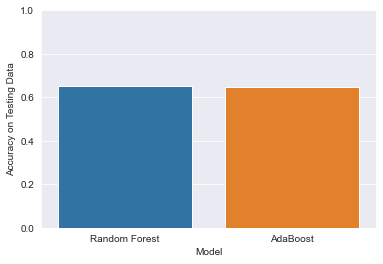

In [38]:
#for testing data
bar_plot_test = sns.barplot(data = df_new, x = 'Model', y = 'Accuracy on Testing Data')
bar_plot_test.set_ylim(0,1)

After we create mixed test data set with fake tasks  fitted it with RandomForest and Adaboost  and give it lower accuracy than the original test data set

With Discriminator/ cascade framework

In [39]:
trained_desc=cond_gan.discriminator
new_labels=keras.utils.to_categorical(New_y_Test,2)
New_x_Test_with_labels=tf.concat([New_x_Test,new_labels],axis=1)
y_pred_new=trained_desc.predict(New_x_Test_with_labels)
y_pred_new=np.apply_along_axis(lambda x:1 if x >0.5 else 0 ,axis=1,arr=y_pred_new)
y_pred_new_df=pd.DataFrame(y_pred_new)
y_pred_new_df

122/122 [==============================] - 0s 1ms/step


,0
0,0
1,0
2,0
3,0
4,0
...,...
3892,1
3893,1
3894,1
3895,1


In [40]:
Real_tasks=y_pred_new_df[y_pred_new_df[0]==1]
Real_tasks

,0
1000,1
1001,1
1002,1
1005,1
1006,1
...,...
3892,1
3893,1
3894,1
3895,1


In [41]:
New_x_Test_df=pd.DataFrame(New_x_Test)
New_x_Test_df

,0,1,2,3,4,5,6,7,8,9,10,11
0,2164.191406,45.525280,-75.250420,3.234113,18.733908,50.271618,33.131824,37.222622,9.351373,65.270920,0.065401,196024.218750
1,2654.715088,45.537876,-75.252861,3.193758,17.586891,52.816406,31.906689,37.692921,9.807094,55.841099,0.035596,183793.390625
2,2793.319336,45.535858,-75.268608,3.711390,18.019270,55.651287,35.540157,42.264355,9.724212,67.410965,0.011787,189091.484375
3,2447.290527,45.540722,-75.238930,3.147765,16.152683,48.160370,38.465481,44.436760,9.722855,63.353432,0.207019,203018.296875
4,2616.924805,45.517120,-75.252983,3.229619,16.571630,48.567574,38.402740,44.091831,9.684939,57.219501,0.086321,200958.437500
...,...,...,...,...,...,...,...,...,...,...,...,...
3892,0.978995,0.443606,-0.620495,0.000000,0.130435,1.000000,1.000000,1.000000,0.777778,0.800000,-1.000000,0.463310
3893,0.440860,-0.619198,0.462170,-0.333333,-0.739130,0.762712,0.600000,-0.600000,-0.555556,-0.542857,-1.000000,-0.609753
3894,-0.097774,0.710110,-0.507246,-1.000000,0.739130,-0.966102,0.200000,-0.600000,0.555556,-0.171429,-1.000000,0.707218
3895,-0.460365,-0.947784,-0.226452,0.000000,1.000000,-1.000000,0.200000,0.200000,0.777778,-0.028571,-1.000000,-0.951267


In [43]:
Real_Features=New_x_Test_df.iloc[Real_tasks.index,:]
Real_Features

,0,1,2,3,4,5,6,7,8,9,10,11
1000,0.993998,0.732562,0.299011,0.666667,-0.913043,0.355932,-0.6,-1.0,-0.777778,-1.000000,-1.0,0.707281
1001,0.295324,0.602653,-0.480717,-1.000000,0.565217,-0.830508,0.2,-0.6,-0.333333,0.542857,-1.0,0.609659
1002,-0.679420,0.497367,-0.598442,-1.000000,0.652174,0.050847,0.6,0.2,-0.333333,-0.085714,-1.0,0.512090
1005,-0.723431,0.853849,-0.753141,0.000000,0.913043,-0.016949,0.2,0.2,0.555556,-0.400000,-1.0,0.853536
1006,-0.272318,0.654998,0.384789,-0.333333,0.043478,-0.186441,-1.0,-1.0,0.111111,-0.742857,-1.0,0.658512
...,...,...,...,...,...,...,...,...,...,...,...,...
3892,0.978995,0.443606,-0.620495,0.000000,0.130435,1.000000,1.0,1.0,0.777778,0.800000,-1.0,0.463310
3893,0.440860,-0.619198,0.462170,-0.333333,-0.739130,0.762712,0.6,-0.6,-0.555556,-0.542857,-1.0,-0.609753
3894,-0.097774,0.710110,-0.507246,-1.000000,0.739130,-0.966102,0.2,-0.6,0.555556,-0.171429,-1.0,0.707218
3895,-0.460365,-0.947784,-0.226452,0.000000,1.000000,-1.000000,0.2,0.2,0.777778,-0.028571,-1.0,-0.951267


In [48]:
Cascade_RF=model_RF.score(Real_Features,Real_tasks)

C:\Users\nadai\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


In [49]:
Cascade_AB=model_AB.score(Real_Features,Real_tasks)

C:\Users\nadai\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(


<AxesSubplot:>

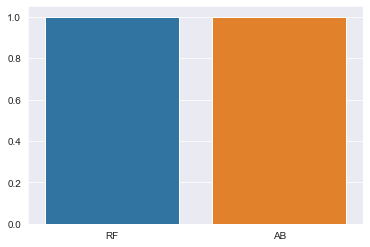

In [46]:
sns.barplot(x=["RF","AB"],y=[Cascade_RF,Cascade_AB])

Discriminator able to remove fake tasks and this help two classifier model (Rf and AB) to classify correctly with high accuracy